# Neural net basics

## Lecture 9

### GRA 4160
### Predictive modelling with machine learning

#### Lecturer: Vegard H. Larsen

In [7]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

Let us look at an example from: 

https://github.com/karpathy/nn-zero-to-hero/

This is a simple library to do automatic differentiation and train a neural network from scratch. 

All libraries today are built on tensors, however, this library work on scalars to illustrate the basic principles.

In [1]:
class Value:
    # Initializer (constructor) for the class
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data  # The actual value
        self.grad = 0.0  # Gradient of this value, initially 0.0
        self._backward = lambda: None  # Placeholder for the backward function
        self._prev = set(_children)  # Previous values that contributed to this value
        self._op = _op  # The operation that produced this value
        self.label = label  # Optional label for the value

    # Representation of the object when printed
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Overloading the addition operator
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # Ensures 'other' is a Value object
        out = Value(self.data + other.data, (self, other), '+')  # Create new Value as sum of self and other
        
        def _backward():
            self.grad += 1.0 * out.grad  # Gradient for addition w.r.t self
            other.grad += 1.0 * out.grad  # Gradient for addition w.r.t other
        out._backward = _backward  # Set the backward function
        
        return out

    # Overloading the multiplication operator
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad  # Gradient for multiplication w.r.t self
            other.grad += self.data * out.grad  # Gradient for multiplication w.r.t other
        out._backward = _backward
        
        return out

    # Overloading the power operator
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad  # Gradient for power operation
        out._backward = _backward

        return out

    # Overloading the reverse multiplication (right multiplication)
    def __rmul__(self, other):
        return self * other

    # Overloading the true division operator
    def __truediv__(self, other):
        return self * other**-1

    # Overloading the negation operator
    def __neg__(self):
        return self * -1

    # Overloading the subtraction operator
    def __sub__(self, other):
        return self + (-other)

    # Overloading the reverse addition (right addition)
    def __radd__(self, other):
        return self + other

    # Method to compute the hyperbolic tangent
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad  # Gradient for tanh function
        out._backward = _backward
        
        return out
    
    # Method to compute the exponential
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad  # Gradient for exponential function
        out._backward = _backward
        
        return out

    # Method to perform backpropagation
    def backward(self):
        # Building a topological sort of nodes for the backward pass
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0  # Starting the backpropagation with a gradient of 1.0
        for node in reversed(topo):  # Iterate over nodes in reverse topological order
            node._backward()  # Call the backward function of each node

In [4]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [5]:
## Backpropagation example throug one neuron

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-1.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(5, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

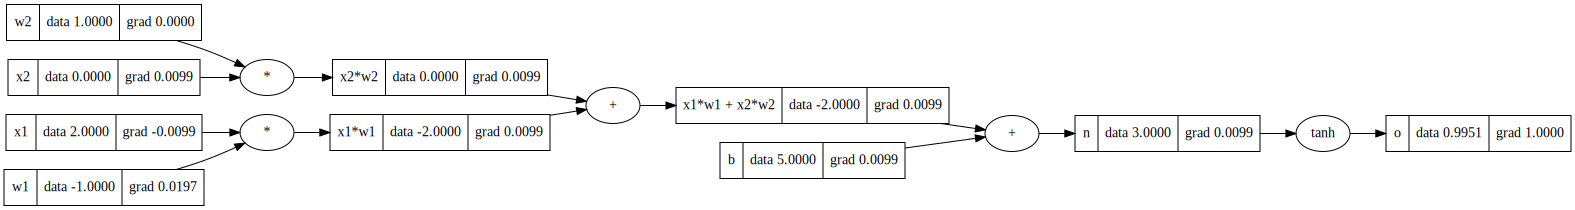

In [11]:
draw_dot(o)

In [10]:
o.backward()

## A multi-layer perceptron

In [12]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [15]:
# A forward pass through the network
x = [2.0, 3.0, -1.0]
n = MLP(3, [3, 3, 1])
n(x)

Value(data=-0.7379686320313101)

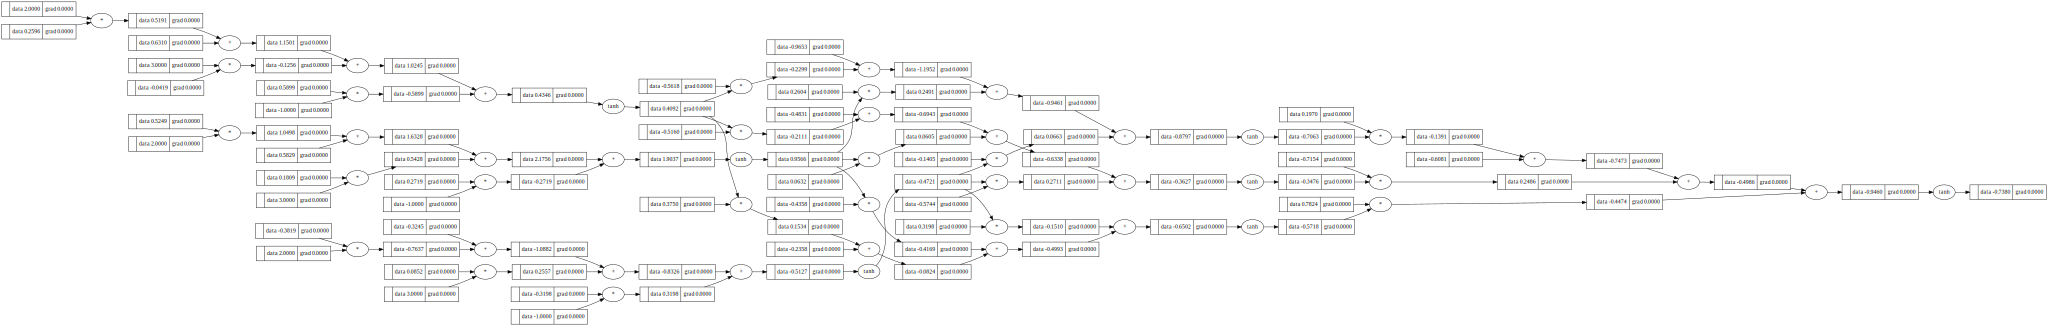

In [16]:
draw_dot(n(x))

In [18]:
# 
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [23]:
for k in range(200):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
    # update
    for p in n.parameters():
        p.data += -1.0 * p.grad
  
    print(k, loss.data)

0 0.0015011016958403419
1 0.0014354191005536711
2 0.0013752002181497435
3 0.0013197912323929483
4 0.0012686386921608986
5 0.001221270948269506
6 0.0011772835672666983
7 0.001136327761521782
8 0.0010981011315295444
9 0.0010623401982688544
10 0.0010288143341104304
11 0.0009973207957334322
12 0.0009676806323060861
13 0.000939735294016434
14 0.0009133438049032832
15 0.000888380393343903
16 0.0008647324959948507
17 0.0008422990682436602
18 0.0008209891476070355
19 0.0008007206269532395
20 0.0007814192026320776
21 0.0007630174690846048
22 0.0007454541366673972
23 0.0007286733535570536
24 0.0007126241159238851
25 0.0006972597532512899
26 0.0006825374778615446
27 0.0006684179894919096
28 0.0006548651272279901
29 0.0006418455623060416
30 0.0006293285262925009
31 0.0006172855699768466
32 0.0006056903490035368
33 0.0005945184328460759
34 0.0005837471342105823
35 0.000573355356364534
36 0.0005633234562310785
37 0.0005536331213817224
38 0.000544267259308801
39 0.0005352098975708324
40 0.00052644609

In [24]:
ypred

[Value(data=0.9944374833908114),
 Value(data=-0.9952898807283656),
 Value(data=-0.9930840687491064),
 Value(data=0.9934010771492566)]